# Import libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import time

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks
from sklearn.utils import class_weight
from keras.models import load_model
from tensorflow.keras.models import Sequential
from sklearn.metrics import confusion_matrix, classification_report

# Load Data

In [2]:
batch_size = 10
img_height = 128
img_width = 128
num_class = 2
train_dir= './Data/init_data/train/'
val_dir= './Data/init_data/validation/'
test_dir= './Data/init_data/test/'
model_dir = './Models/model_mobile_init/'

In [3]:
# Data for Training
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='categorical',
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=True,
)

Found 2520 files belonging to 2 classes.


2022-06-21 00:53:09.205192: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-21 00:53:09.240486: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-21 00:53:09.240775: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-21 00:53:09.241628: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [4]:
# Data for validation
val_ds = tf.keras.utils.image_dataset_from_directory(
        val_dir,
        labels='inferred',
        label_mode='categorical',
        batch_size=batch_size,
        image_size=(img_height, img_width),
        shuffle=True,
)

Found 637 files belonging to 2 classes.


In [5]:
# Data for Testing
test_ds = tf.keras.utils.image_dataset_from_directory(
        test_dir,
        labels='inferred',
        label_mode='categorical',
        batch_size=batch_size,
        image_size=(img_height, img_width),
        shuffle=True,
)

Found 1090 files belonging to 2 classes.


In [6]:
class_names = train_ds.class_names
print(class_names)

['with_mask', 'without_mask']


In [7]:
# Get weights to balance classes

lab =[]
for images, labels in train_ds.take(-1):  
    lab.extend(labels.numpy())

tru=[]
for i in lab:
    tru.append(np.argmax(i))
    

tru
class_weights = class_weight.compute_class_weight('balanced',
                                                  classes=np.unique(tru),
                                                  y=tru)
name = [0,1]
weight = dict(zip(name,class_weights))
print(weight)

{0: 0.6116504854368932, 1: 2.739130434782609}


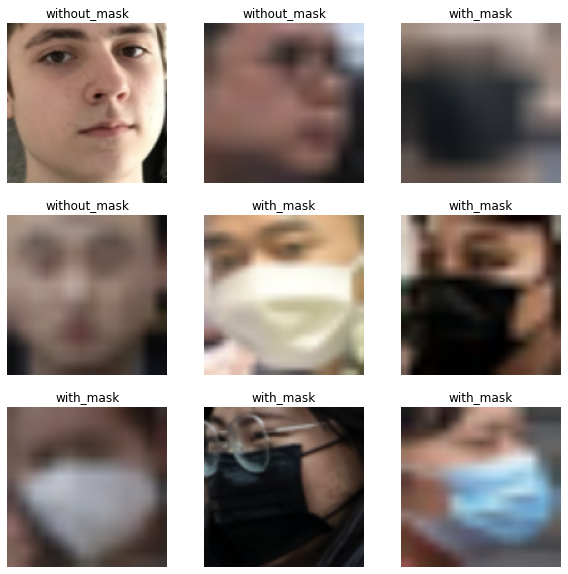

In [8]:
# Show some images
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[np.argmax(labels[i])])
        plt.axis("off")

# Data augmentation

In [9]:
# Add some augmentation layers to change the imputs pictures slightly
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomBrightness(0.1, value_range=(1,250)),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1)
])

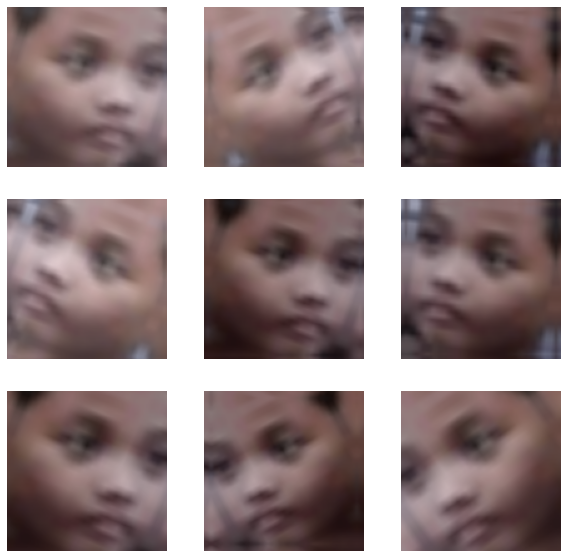

In [10]:
# Show some augmented images
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images, training=True)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype(np.uint8))
        plt.axis("off")

# Create model

In [11]:
# Create base model with MobileNetV2 architecture
base_model = keras.applications.MobileNetV2(
    weights='imagenet',  # load pretrained ImageNet weights
    input_shape=(img_width, img_height, 3),
    include_top=False)  # Delete last layer of the model 

# Freeze pretrained weights
base_model.trainable = False

# Create the imput of our model
inputs= keras.Input(shape=(img_height, img_width, 3))

#  Augmentation
x = data_augmentation(inputs)

# Add a preprocessing layer specific to this architecture
x = keras.applications.mobilenet_v2.preprocess_input(x)

# Add both models
x = base_model(x, training=False)

# Convert our features vector into a 1-D vector
x = keras.layers.GlobalAveragePooling2D()(x)

# Add a Dropout layer to stop overfitting
x = keras.layers.Dropout(0.5)(x)

# Add a final layer with our classes
outputs = keras.layers.Dense(num_class, activation='softmax')(x)

# Final model
model = keras.Model(inputs, outputs)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 128, 128, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 128, 128, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 128, 128, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_128 (Funct  (None, 4, 4, 1280)       2257984   
 ional)                                                          
                                                             

In [12]:
opt = keras.optimizers.SGD(learning_rate=0.01)

# Compile the model
model.compile(
    optimizer=opt,
    loss='binary_crossentropy',
    metrics= ['accuracy']
)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 128, 128, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 128, 128, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 128, 128, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_128 (Funct  (None, 4, 4, 1280)       2257984   
 ional)                                                          
                                                             

# First Round of training

In [13]:
# Add some callbacks to stop the fit process if needed
my_callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath= model_dir + 'checkpoint/',
        monitor="val_accuracy",
        verbose=0,
        save_best_only=True,
        save_weights_only=True,
        mode="auto",
        save_freq="epoch",
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=5,
        verbose=1,
        mode="auto",
        restore_best_weights=True,
    ),
]

# Train the model
history = model.fit(
    train_ds,
    class_weight=weight,
    validation_data=val_ds,
    epochs=50,
    batch_size = batch_size,
    callbacks=my_callbacks
)


Epoch 1/50


2022-06-21 00:53:32.365444: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8400


252/252 [==============================] - 32s 90ms/step - loss: 0.4568 - accuracy: 0.7972 - val_loss: 0.3464 - val_accuracy: 0.8305
Epoch 2/50
252/252 [==============================] - 20s 78ms/step - loss: 0.3307 - accuracy: 0.8452 - val_loss: 0.2666 - val_accuracy: 0.8713
Epoch 3/50
252/252 [==============================] - 21s 83ms/step - loss: 0.3085 - accuracy: 0.8615 - val_loss: 0.2581 - val_accuracy: 0.8823
Epoch 4/50
252/252 [==============================] - 21s 83ms/step - loss: 0.2930 - accuracy: 0.8659 - val_loss: 0.1859 - val_accuracy: 0.9184
Epoch 5/50
252/252 [==============================] - 21s 83ms/step - loss: 0.2909 - accuracy: 0.8623 - val_loss: 0.1477 - val_accuracy: 0.9403
Epoch 6/50
252/252 [==============================] - 21s 83ms/step - loss: 0.2813 - accuracy: 0.8710 - val_loss: 0.1795 - val_accuracy: 0.9231
Epoch 7/50
252/252 [==============================] - 22s 86ms/step - loss: 0.2659 - accuracy: 0.8750 - val_loss: 0.4173 - val_accuracy: 0.8006
Epo

In [14]:
# Save the model
model.save(model_dir+'Model/')

INFO:tensorflow:Assets written to: ./Models/model_mobile_init/Model/assets


INFO:tensorflow:Assets written to: ./Models/model_mobile_init/Model/assets


# Results

In [15]:
# Verify our model with the test data
lab =[]
preds = []
for images, labels in test_ds.take(-1):  
    lab.extend(labels.numpy())
    preds.extend(model.predict(images,verbose=0))

tru=[]
for i in lab:
    tru.append(np.argmax(i))
    
pre = []
for i in preds:
    pre.append(np.argmax(i))
    
print('Confusion:','\n',confusion_matrix(tru,pre),'\n')
print(classification_report(tru, pre,target_names=class_names,digits=num_class))

Confusion: 
 [[588   2]
 [  2 498]] 

              precision    recall  f1-score   support

   with_mask       1.00      1.00      1.00       590
without_mask       1.00      1.00      1.00       500

    accuracy                           1.00      1090
   macro avg       1.00      1.00      1.00      1090
weighted avg       1.00      1.00      1.00      1090



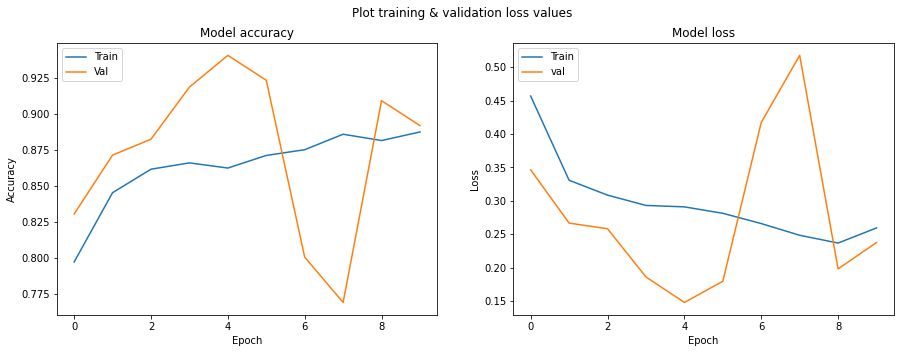

In [16]:
# Fit graphs
fig, (ax1, ax2) = plt.subplots(1, 2,figsize = (15,5))

fig.suptitle('Plot training & validation loss values')
ax1.plot(history.history['accuracy'])
ax1.plot(history.history['val_accuracy'])
ax1.set_title('Model accuracy')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')
ax1.legend(['Train', 'Val'], loc='upper left')

ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.set_title('Model loss')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.legend(['Train', 'val'], loc='upper left')

plt.show()

# Second round of training

In [17]:
# Train the model a second time with the whole model unfreezed
base_model.trainable = True
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 128, 128, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 128, 128, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 128, 128, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_128 (Funct  (None, 4, 4, 1280)       2257984   
 ional)                                                          
                                                             

In [18]:
# Compile the model again
model.compile(
    optimizer=keras.optimizers.SGD(learning_rate=1e-6),  # Low learning rate
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Add some callbacks to stop the fit process if needed
my_callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath=model_dir +'checkpoint/',
        monitor="val_accuracy",
        verbose=0,
        save_best_only=True,
        save_weights_only=True,
        mode="auto",
        save_freq="epoch",
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=2,
        verbose=1,
        mode="auto",
        restore_best_weights=True,
    ),
]

# Train the model again
history = model.fit(
    train_ds, 
    class_weight=weight,
    validation_data=val_ds,
    epochs=10,
    batch_size = batch_size,
    callbacks=my_callbacks
)

Epoch 1/10


252/252 [==============================] - 66s 210ms/step - loss: 0.2922 - accuracy: 0.8952 - val_loss: 0.1654 - val_accuracy: 0.9294
Epoch 2/10
252/252 [==============================] - 49s 193ms/step - loss: 0.2760 - accuracy: 0.8992 - val_loss: 0.2072 - val_accuracy: 0.9105
Epoch 3/10
252/252 [==============================] - 48s 192ms/step - loss: 0.2482 - accuracy: 0.9024 - val_loss: 0.2216 - val_accuracy: 0.9011
Epoch 3: early stopping


In [19]:
# Save the model
model.save(model_dir+'Model/')

INFO:tensorflow:Assets written to: ./Models/model_mobile_init/Model/assets


INFO:tensorflow:Assets written to: ./Models/model_mobile_init/Model/assets


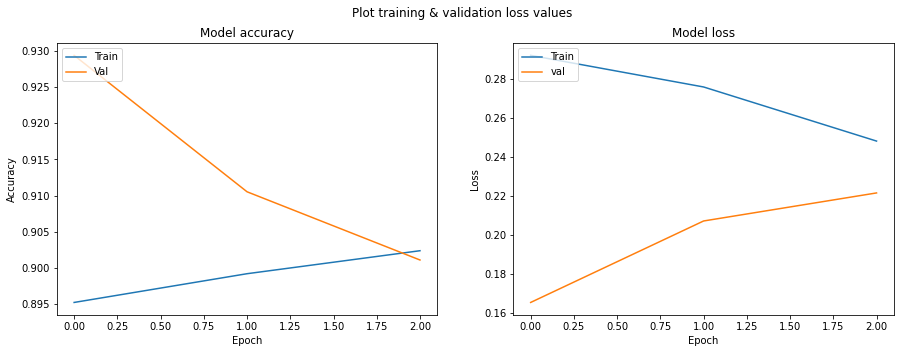

In [20]:
# Fit graphs
fig, (ax1, ax2) = plt.subplots(1, 2,figsize = (15,5))

fig.suptitle('Plot training & validation loss values')
ax1.plot(history.history['accuracy'])
ax1.plot(history.history['val_accuracy'])
ax1.set_title('Model accuracy')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')
ax1.legend(['Train', 'Val'], loc='upper left')

ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.set_title('Model loss')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.legend(['Train', 'val'], loc='upper left')

plt.show()

In [21]:
# Verify our model with the test data again 
lab =[]
preds = []
for images, labels in test_ds.take(-1):  
    lab.extend(labels.numpy())
    preds.extend(model.predict(images,verbose=0))

tru=[]
for i in lab:
    tru.append(np.argmax(i))
    
pre = []
for i in preds:
    pre.append(np.argmax(i))

print('Confusion:','\n',confusion_matrix(tru,pre),'\n')
print(classification_report(tru, pre,target_names=class_names, digits=num_class))

Confusion: 
 [[586   4]
 [  2 498]] 

              precision    recall  f1-score   support

   with_mask       1.00      0.99      0.99       590
without_mask       0.99      1.00      0.99       500

    accuracy                           0.99      1090
   macro avg       0.99      0.99      0.99      1090
weighted avg       0.99      0.99      0.99      1090

